In [1]:
import torch
from torch import tensor
from torch.autograd import grad
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log10, floor, ceil, frexp

In [2]:
all_values = []
all_errors = []
values_dict = {}

def mnk(x, y):
    b = (np.mean(x*y) - np.mean(x)*np.mean(y))/(np.mean(x**2) - np.mean(x)**2)
    a = np.mean(y) - b*np.mean(x)
    sb = 1/np.sqrt(len(x)) * np.sqrt((np.mean(y**2) - np.mean(y)**2)/(np.mean(x**2) - np.mean(x)**2) - b**2)
    sa = sb*np.sqrt(np.mean(x**2) - np.mean(x)**2)
    
    return a, b, sa, sb

def value(x, err):
    values_dict[x] = err
    
    x = tensor(x, requires_grad=True, dtype=torch.float64)
    all_values.append(x)
    all_errors.append(err)
    return x

def get_error(x):
    grads = grad(x, all_values, retain_graph=True, allow_unused=True)
    res = 0
    for i, error in enumerate(all_errors):
        if grads[i] is not None:
            res += (grads[i]*error)**2
    return res**0.5

def get_man_exp(x):
    e = floor(log10(x))
    m = x * 10**(-e)
    return m, e

def round2one(err):
    m, e = get_man_exp(err)
    m = round(m, 1)
    if int(m) in [1, 2]:
        return int(m*10), e - 1
    else:
        return int(m + 1), e
    
def science_notation(x, err):
    err, er = round2one(err)
    x = round(x, -er)
    m, e = get_man_exp(x)
    
    if abs(e) <= 1:
        print(f'${x} \\pm {err * 10 ** (er)}$')
    else:
        print(f'$({m} \\pm {err * 10 ** (-e+er)}) \\cdot 10^{"{" + str(e) + "}"}$')

def show(x, dx):
    x = float(x.detach())
    dx = float(dx)
    return science_notation(x, dx)

In [3]:
# стартовые параметры

g = 9.8

R = value(115.5 / 1000, 0.5 / 1000)
r = value(30.2 / 1000, 0.3 / 1000)
m = value(1026.4 / 1000, 0.5 / 1000)
l = value(2160. / 1000, 10 / 1000)

In [4]:
# параметры грузов
m1 = value(730.4 / 1000, 0.1 / 1000)
r1_in = value(75.2 / 1000, 0.1 / 1000)
r1_out = value(79.3 / 1000, 0.1 / 1000)

m2 = value(584.1 / 1000, 0.1 / 1000)
r1 = value(5.2 / 1000, 0.1 / 1000)
r2 = value(85.3 / 1000, 0.1 / 1000)
h0 = value(3.6 / 1000, 0.1 / 1000)
h1 = value(26 / 1000, 0.1 / 1000)

## Расчёт константы установки

In [5]:
z0 = (l**2 - (R - r)**2)**0.5
dz0 = get_error(z0)
show(z0, dz0)

$2.158 \pm 0.01$


In [6]:
k = g*R*r/(4*np.pi**2*z0)
dk = get_error(k)
show(k, dk)
print(dk/k*100)

$(4.01 \pm 0.05) \cdot 10^{-4}$
tensor(1.1785, dtype=torch.float64, grad_fn=<MulBackward0>)


## Расчёт моментов инерции грузов (теор)

In [7]:
I1 = 1 / 2 * m1 * (r1_in**2 + r1_out**2)
dI1 = get_error(I1)
show(I1, dI1)

$(4.362 \pm 0.009000000000000001) \cdot 10^{-3}$


In [8]:
I2 = m2 / 2 * (r1**4 * h1 + r2**4 * h0) / (r1**2 * h1 + r2**2 * h0)
dI2 = get_error(I2)
show(I2, dI2)

$(2.07 \pm 0.006) \cdot 10^{-3}$


## Расчёт начального момента инерции

In [9]:
T0 = value(4.401, 0.01 / 20)

In [10]:
I0 = k*m*T0**2
dI0 = get_error(I0)
show(I0, dI0)

$(7.9799999999999995 \pm 0.1) \cdot 10^{-3}$


## Проверка аддитивности моментов инерции

In [11]:
T11 = value(4.186, 0.01 / 20)
T22 = value(3.948, 0.01 / 20)
T12 = value(3.928, 0.01 / 20)

In [12]:
I1_exp = k*(m1 + m)*T11**2 - I0
I2_exp = k*(m2 + m)*T22**2 - I0
I12_exp = k*(m1 + m2 + m)*T12**2 - I0

In [13]:
dI1_exp = get_error(I1_exp)
dI2_exp = get_error(I2_exp)
dI12_exp = get_error(I12_exp)

In [14]:
show(I1_exp, dI1_exp)
print(float(dI1_exp/I1_exp*100))

$(4.37 \pm 0.06) \cdot 10^{-3}$
1.1813145205803592


In [15]:
show(I2_exp, dI2_exp)
print(float(dI2_exp/I2_exp*100))

$(2.095 \pm 0.025) \cdot 10^{-3}$
1.1888720754886963


In [16]:
show(I12_exp, dI12_exp)
print(float(dI12_exp/I12_exp*100))

$(6.51 \pm 0.08) \cdot 10^{-3}$
1.1803461398466502


In [17]:
(I1_exp + I2_exp - I12_exp)/get_error(I1_exp + I2_exp - I12_exp)

tensor(-7.8971, dtype=torch.float64, grad_fn=<DivBackward0>)

## Нахождение момента инерции тела методом сдвига

In [17]:
df = pd.read_csv('data/3.txt')
df.h /= 100
df

,T,h
0,3.069,0.0000
1,3.081,0.0096
2,3.104,0.0192
3,3.117,0.0288
4,3.168,0.0384
5,3.216,0.0480
6,3.281,0.0576
7,3.355,0.0672
8,3.442,0.0768
9,3.537,0.0864


In [26]:
print(df.style.to_latex())

\begin{tabular}{lrrrr}
 & T & h & $h^2$ & $T^2$ \\
0 & 3.069000 & 0.000000 & 0.000000 & 9.418761 \\
1 & 3.081000 & 0.009600 & 0.000092 & 9.492561 \\
2 & 3.104000 & 0.019200 & 0.000369 & 9.634816 \\
3 & 3.117000 & 0.028800 & 0.000829 & 9.715689 \\
4 & 3.168000 & 0.038400 & 0.001475 & 10.036224 \\
5 & 3.216000 & 0.048000 & 0.002304 & 10.342656 \\
6 & 3.281000 & 0.057600 & 0.003318 & 10.764961 \\
7 & 3.355000 & 0.067200 & 0.004516 & 11.256025 \\
8 & 3.442000 & 0.076800 & 0.005898 & 11.847364 \\
9 & 3.537000 & 0.086400 & 0.007465 & 12.510369 \\
10 & 3.630000 & 0.096000 & 0.009216 & 13.176900 \\
11 & 3.852000 & 0.115200 & 0.013271 & 14.837904 \\
\end{tabular}



In [19]:
df.h**2

0     0.000000
1     0.000092
2     0.000369
3     0.000829
4     0.001475
5     0.002304
6     0.003318
7     0.004516
8     0.005898
9     0.007465
10    0.009216
11    0.013271
Name: h, dtype: float64

In [20]:
2 * 0.1152 * 1/1000, 2 * 3.852 * 0.01 / 20

(0.0002304, 0.003852)

$9.429 \pm 0.009000000000000001$
$(4.078 \pm 0.02) \cdot 10^{2}$
None None


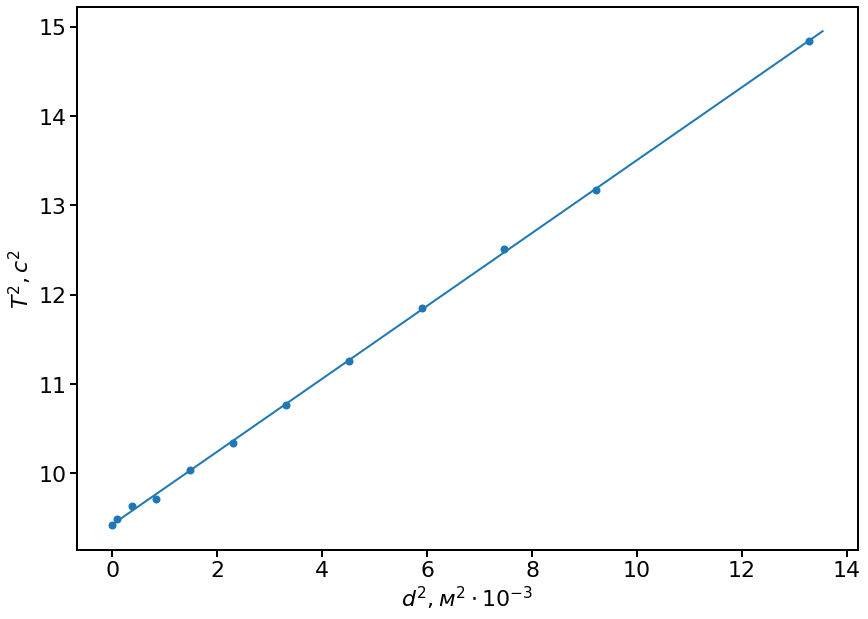

In [21]:
plt.rc('font', size=22)

fig, ax = plt.subplots(figsize=(14, 10))
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

ax.xaxis.set_tick_params(width=2, length=7)
ax.yaxis.set_tick_params(width=2, length=7)

ax.scatter(df.h**2 * 1000, df['T']**2, linewidth=2)
a, b, sa, sb = mnk(df.h**2, df['T']**2)

X = np.array([min(df.h**2 * 1000)*0.9, max(df.h**2 * 1000)*1.02])
Y = a + b*X/1000
ax.plot(X, Y, linewidth=2)
L = b
sL = sb
Mtr1 = -a

ax.set_xlabel(r"$d^2, м^2 \cdot 10^{-3}$")
ax.set_ylabel(r"$T^2, с^2$")

fig.savefig(r'D:\LabProjects\1.2.3\report\images\1.eps', format='eps')

sa = np.sqrt(0.003852**2 + sa**2)
sb = np.sqrt(0.0002304**2 + sb**2)
print(science_notation(a, sa), science_notation(b, sb))

In [22]:
(a, sa), (b, sb)

((9.429290780520688, 0.00894681296695206),
 (407.8290044139507, 2.012411400308985))

In [23]:
k_g = value(407.8290044139507, 2.012411400308985)
b_g = value(9.429290780520684, 0.008075119705917306)

In [24]:
M = value(763.45 / 1000, 0.1 / 1000)

In [25]:
k_diff = M / (2 * (2 * M + m) * k_g)
dk_diff = get_error(k_diff)
show(k_diff, dk_diff)
print(float(dk_diff/k_diff)*100)

$(3.6660000000000004 \pm 0.018000000000000002) \cdot 10^{-4}$
0.49386138034029464


In [26]:
show(k, dk)
print(float(dk/k*100))

$(4.01 \pm 0.05) \cdot 10^{-4}$
1.1785197641197487


In [33]:
Ik = (b_g*k*(2 * M + m) - I0) / 2
dIk = get_error(Ik)
show(Ik, dIk)
print(float(dIk/Ik)*100)

$(8.42 \pm 0.11) \cdot 10^{-4}$
1.2876492460432354


## Теор расчёт искомого момента инерции

In [30]:
Rt = value(45.6 / 1000, 0.1 / 1000)

In [31]:
Ikt = M*Rt**2/2
dIkt = get_error(Ikt)
show(Ikt, dIkt)
print(float(dIkt/Ikt)*100)

$(7.94 \pm 0.04) \cdot 10^{-4}$
0.4387920362884169
